The purpose of this notebook is for me to experiment with the use of LSTM networks to predict/extrapolate the Apple Stock Price in time.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

Begin by loading in the dataset. This dataset includes information on the Apple stock ticker from 2013 to 2018.

In [3]:
#the training data is all info prior to January 2018
train = pd.read_csv('AAPL.xls')
train.head()

,Date,Open
0,1/2/2013,79.117142
1,1/3/2013,78.268570
2,1/4/2013,76.709999
3,1/7/2013,74.571426
4,1/8/2013,75.601425


In [4]:
#the testing data will be the data for the month of January 2018
test = pd.read_csv("AAPL - Jan2018.xls")
test.head()

,Date,Open
0,1/2/2018,170.160004
1,1/3/2018,172.529999
2,1/4/2018,172.539993
3,1/5/2018,173.440002
4,1/8/2018,174.350006


Let's perform some EDA on the training data so that we may understand it better.

In [5]:
#how many records are we looking at?
train.shape

(1259, 2)

In [6]:
#are any records/dates null?
train.isnull().sum()

Date    0
Open    0
dtype: int64

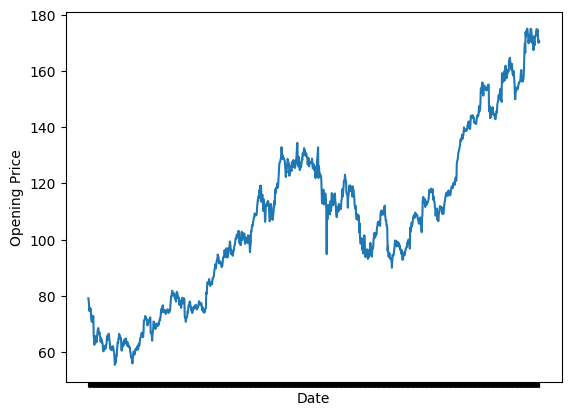

In [51]:
#let's visualize what the stock performance was like over time
plt.plot(train.Date, train.Open)
plt.xlabel("Date")
plt.ylabel("Opening Price")
plt.xticks(visible = False)
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x782f4d8f0490>,
 'caps': [<matplotlib.lines.Line2D at 0x782f4d8f0d60>,
 'boxes': [<matplotlib.lines.Line2D at 0x782f4d8f0850>],
 'medians': [<matplotlib.lines.Line2D at 0x782f4d8f0d90>],
 'fliers': [<matplotlib.lines.Line2D at 0x782f4d8f0eb0>],
 'means': []}

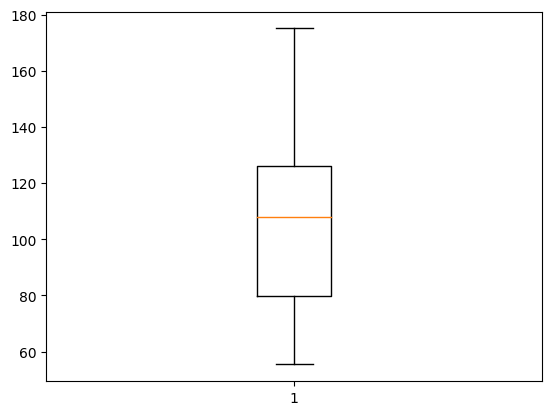

In [ ]:
#what does the distribution of prices look like (5 years is a long time)
plt.boxplot(train.Open)

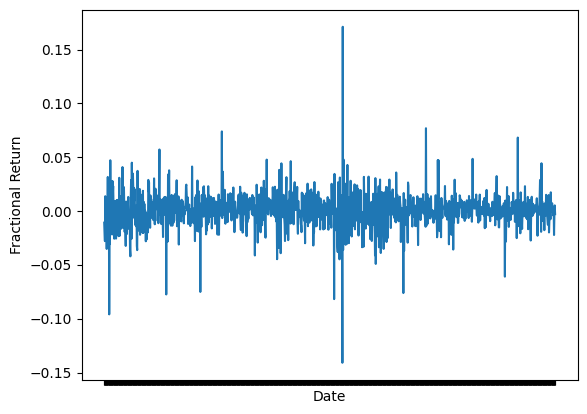

In [6]:
#what did the daily returns look like for the Apple stock?
# were there any days whose performance really stood out from the rest?

train['Daily_Return'] = train['Open'].pct_change()
plt.plot(train.Date, train.Daily_Return)
plt.xlabel('Date')
plt.xticks(visible = False)
plt.ylabel("Fractional Return")
plt.show()

In [ ]:
#I wonder what happened on the day when the return was above 15%? hmmm... apparently Apple was not the only ticker to have a rebound that day
train.Date[np.where(train.Daily_Return > 0.15)[0]]

666    8/25/2015
Name: Date, dtype: object

Now that we have taken a look at the beheavior of the data, we can begin applying some preprocessing steps. These include:
- removing the date feature from the set of training features for now (NOTE: it may be worthwhile to try engineering some timestamp features to help model performance at a later point)
- scaling the data to a common range


At this point, let us try to only train the model on the opening prices of the stock. We bein by extracting this feature and scaling the prices to a common range.
- For scaling purposes, let us use MinMaxScaler since we do not want to distort the data

In [52]:
#extract the opening price from the data
train_price =  train.iloc[:, 1:2]
train_price

,Open
0,79.117142
1,78.268570
2,76.709999
3,74.571426
4,75.601425
...,...
1254,174.679993
1255,170.800003
1256,170.100006
1257,171.000000


In [53]:
# now scale the data (MinMaxScaler)
scaler = MinMaxScaler(feature_range = (0,1))
train_price_scaled = scaler.fit_transform(train_price)


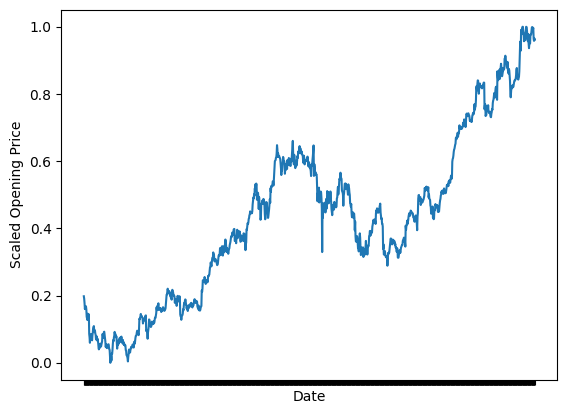

In [ ]:
plt.plot(train.Date, train_price_scaled)
plt.xticks(visible = False)
plt.xlabel("Date")
plt.ylabel("Scaled Opening Price")
plt.show()

Now, let us reshape the input data to three dimensions for input to the LSTM network. We will define the data as having 60 timesteps with one feature at each timestep.

In [54]:
train_price_scaled.shape

(1259, 1)

In [55]:
features_set = []
labels = []

for i in range(60, train_price_scaled.shape[0]):
  features_set.append(train_price_scaled[i-60:i, 0])
  labels.append(train_price_scaled[i,0])

In [56]:
# now convert the results to np arrays for better use going forwards (they are lists as of now)
features_set, labels = np.array(features_set), np.array(labels)

In [57]:
# now construct the three-dimensional array for network input
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
print(features_set.shape)

(1199, 60, 1)


In [58]:
features_set.shape, labels.shape

((1199, 60, 1), (1199,))

Now, let us build up the architecture for the LSTM network.
- We can start with 300 nodes in the input layer, one in the output layer, and three hidden layers with 100 units each.
-  Let us also use Dropout to prevent overfitting. A Dropout rate of 0.2 should be a good place to start.

In [ ]:
model = Sequential()

# input layer
model.add(LSTM(units = 300,
               return_sequences = True,
               input_shape = (features_set.shape[1], 1)))
model.add(Dropout(0.2))

# first hidden layer
model.add(LSTM(units = 100,
               return_sequences = True))
model.add(Dropout(0.2))

# second hidden layer
model.add(LSTM(units = 100,
               return_sequences = True))
model.add(Dropout(0.2))

# third hidden layer
model.add(LSTM(units = 100,
               return_sequences = False)) # we want the final hidden layer and output layers to be two dimensional
model.add(Dropout(0.2))

#the output layer
model.add(Dense(units = 1))

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 300)           362400    
                                                                 
 dropout (Dropout)           (None, 60, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 100)           160400    
                                                                 
 dropout_1 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_2 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               8

In [ ]:
# alright, let's go ahead and train the model
# to do this, we will split the data up into 32 batches and train over 300 epochs to start
# let's also visualize the training error over time to gauge the learning process
history = model.fit(features_set, labels, epochs = 300, batch_size = 32, validation_split = 0.3)

Epoch 1/300
27/27 [==============================] - 21s 486ms/step - loss: 0.0122 - val_loss: 0.0022
Epoch 2/300
27/27 [==============================] - 11s 403ms/step - loss: 0.0025 - val_loss: 0.0205
Epoch 3/300
27/27 [==============================] - 11s 399ms/step - loss: 0.0027 - val_loss: 0.0165
Epoch 4/300
27/27 [==============================] - 12s 431ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 5/300
27/27 [==============================] - 11s 428ms/step - loss: 0.0024 - val_loss: 0.0073
Epoch 6/300
27/27 [==============================] - 11s 417ms/step - loss: 0.0021 - val_loss: 0.0124
Epoch 7/300
27/27 [==============================] - 11s 423ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 8/300
27/27 [==============================] - 11s 427ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 9/300
27/27 [==============================] - 12s 433ms/step - loss: 0.0018 - val_loss: 0.0111
Epoch 10/300
27/27 [==============================] - 12s 432ms/step - loss: 0.001

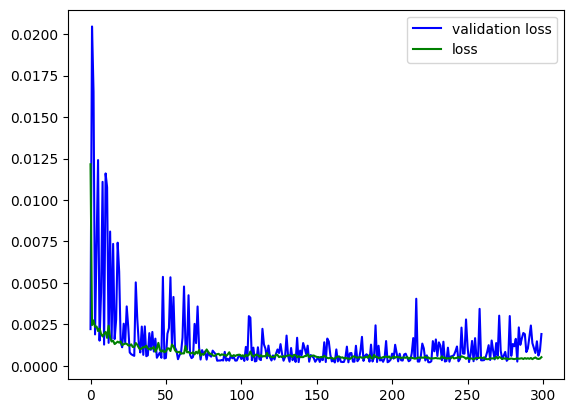

In [ ]:
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation loss')
plt.plot(history.history['loss'], color = 'green', label = 'loss')
plt.legend()
plt.show()

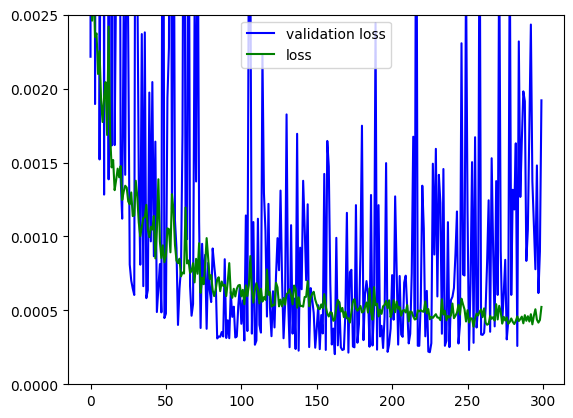

In [ ]:
#let's zoom in on that validation loss
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation loss')
plt.plot(history.history['loss'], color = 'green', label = 'loss')
plt.legend()
plt.ylim([0,0.0025])
plt.show()

It looks like after around 200 epochs, the validation error seems to level off. This would be sufficient for training. Let's re-train and then try to generate some predictions for the month of January 2018.

In [ ]:
# first, we have to re-compile the model

model = Sequential()

# input layer
model.add(LSTM(units = 300,
               return_sequences = True,
               input_shape = (features_set.shape[1], 1)))
model.add(Dropout(0.2))

# first hidden layer
model.add(LSTM(units = 100,
               return_sequences = True))
model.add(Dropout(0.2))

# second hidden layer
model.add(LSTM(units = 100,
               return_sequences = True))
model.add(Dropout(0.2))

# third hidden layer
model.add(LSTM(units = 100,
               return_sequences = False)) # we want the final hidden layer and output layers to be two dimensional
model.add(Dropout(0.2))

#the output layer
model.add(Dense(units = 1))

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 300)           362400    
                                                                 
 dropout_4 (Dropout)         (None, 60, 300)           0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 100)           160400    
                                                                 
 dropout_5 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_6 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100)              

In [ ]:
# alright, let's go ahead and train the model
# to do this, we will split the data up into 32 batches and train over 300 epochs to start
# let's also visualize the training error over time to gauge the learning process
history = model.fit(features_set, labels, epochs = 200, batch_size = 32, validation_split = 0.3)

Epoch 1/200
27/27 [==============================] - 24s 568ms/step - loss: 0.0279 - val_loss: 0.0049
Epoch 2/200
27/27 [==============================] - 12s 461ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 3/200
27/27 [==============================] - 12s 464ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 4/200
27/27 [==============================] - 14s 506ms/step - loss: 0.0024 - val_loss: 0.0083
Epoch 5/200
27/27 [==============================] - 14s 531ms/step - loss: 0.0022 - val_loss: 0.0053
Epoch 6/200
27/27 [==============================] - 23s 856ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 7/200
27/27 [==============================] - 16s 598ms/step - loss: 0.0024 - val_loss: 0.0065
Epoch 8/200
27/27 [==============================] - 12s 451ms/step - loss: 0.0021 - val_loss: 0.0076
Epoch 9/200
27/27 [==============================] - 12s 453ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 10/200
27/27 [==============================] - 14s 511ms/step - loss: 0.002

Now, let's begin evaluation on the model.

In [ ]:
#gather and apply preprocessing to the testing dataset
test_prices = test.iloc[:,1:2].values

all_prices = pd.concat((train["Open"], test['Open']), axis = 0).values

X = all_prices[len(all_prices) - len(test) - 60:]
X = X.reshape(-1,1)

X = scaler.transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
test_features = []
for i in range(60, len(X)):
  test_features.append(X[i-60:i, 0])

test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
test_features.shape

(20, 60, 1)

In [ ]:
#now, let's generate the predictions
preds = model.predict(test_features)
preds = scaler.inverse_transform(preds)

1/1 [==============================] - 0s 140ms/step


In [ ]:
#append them to the testing values for comparison
df_preds = test[['Date', 'Open']]
df_preds['Open_Pred'] = preds
df_preds.head()

,Date,Open,Open_Pred
0,1/2/2018,170.160004,167.601105
1,1/3/2018,172.529999,166.995026
2,1/4/2018,172.539993,168.757156
3,1/5/2018,173.440002,169.056900
4,1/8/2018,174.350006,169.625366


In [ ]:
preds.shape

(20, 1)

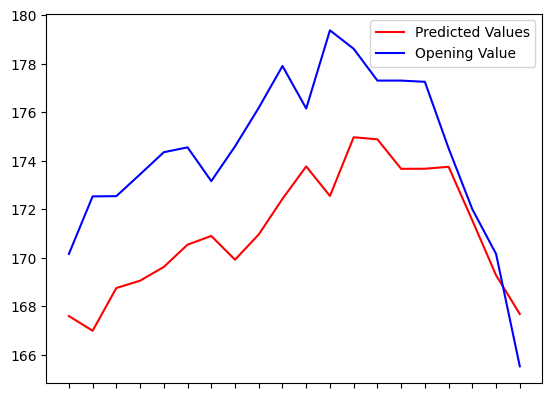

In [ ]:
#now, let's visualize our predicted values
plt.plot(df_preds['Date'], df_preds['Open_Pred'], color = 'red', label = 'Predicted Values')
plt.plot(df_preds['Date'], df_preds['Open'], color = 'blue', label = 'Opening Value')
plt.legend()
plt.xticks(visible = False)
plt.show()

# Attempt 2:

Now that I have built up a first iteration of the model, I am curious how adding additional features to the model, such as datime features, will help the model's performance.

- The two datetime features I would like to introduce to the dataset are the day of the week and the month of the year. These features should account for behaviour trends that take place based on the times of the week as well as seasonal behaviours
 in the market (encode some kind of information on the financial quarter, for example).

In [7]:
#let's begin by introducing some datetime information to the feature set:
train['Month'] = pd.DatetimeIndex(train['Date']).month
train['Day'] = pd.DatetimeIndex(train['Date']).day_name()
train.head()

,Date,Open,Month,Day
0,1/2/2013,79.117142,1,Wednesday
1,1/3/2013,78.268570,1,Thursday
2,1/4/2013,76.709999,1,Friday
3,1/7/2013,74.571426,1,Monday
4,1/8/2013,75.601425,1,Tuesday


In [8]:
#we also have to be sure to conver the Day feature to take on numerical factors
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
train['Day_Coded'] = encoder.fit_transform(train[['Day']])
train.head(15)

,Date,Open,Month,Day,Day_Coded
0,1/2/2013,79.117142,1,Wednesday,4.0
1,1/3/2013,78.268570,1,Thursday,2.0
2,1/4/2013,76.709999,1,Friday,0.0
3,1/7/2013,74.571426,1,Monday,1.0
4,1/8/2013,75.601425,1,Tuesday,3.0
5,1/9/2013,74.642860,1,Wednesday,4.0
6,1/10/2013,75.507141,1,Thursday,2.0
7,1/11/2013,74.428574,1,Friday,0.0
8,1/14/2013,71.811432,1,Monday,1.0
9,1/15/2013,71.185715,1,Tuesday,3.0


In [9]:
#check that the encoding worked the way we wanted it to
train.Day_Coded.value_counts(), train.Day.value_counts()

(4.0    259
 3.0    259
 2.0    253
 0.0    252
 1.0    236
 Name: Day_Coded, dtype: int64,
 Wednesday    259
 Tuesday      259
 Thursday     253
 Friday       252
 Monday       236
 Name: Day, dtype: int64)

In [10]:
#alright, that seems to be in order, let's select the features we want for preprocessing
train_features = train[['Open', 'Month', 'Day_Coded']].values

In [11]:
#initialize a separate scaler for this model iteration
scaler_2 = MinMaxScaler(feature_range = (0,1))
train_scaled = scaler_2.fit_transform(train_features)
train_scaled.shape

(1259, 3)

In [12]:
#now reshape the array for training
features_set = []
labels = []

for i in range(60, train_scaled.shape[0]):
  features_set.append(train_scaled[i-60:i, :])
  labels.append(train_scaled[i,0])

In [13]:
#convert to arrays and check the shapes are as we expect
features_set, labels = np.array(features_set), np.array(labels)
features_set.shape, labels.shape

((1199, 60, 3), (1199,))

In [18]:
#start building up the model architecture
model = Sequential()
#the input layer
model.add(LSTM(units = 300, return_sequences = True, input_shape = (features_set.shape[1],3)))
model.add(Dropout(0.2))
#the first hidden layer
model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))
#the second hidden layer
model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))
#the third hidden layer
model.add(LSTM(units = 100))
model.add(Dropout(0.2))
#the output layer
model.add(Dense(units = 1))
#return model


In [19]:
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error')

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 300)           364800    
                                                                 
 dropout_4 (Dropout)         (None, 60, 300)           0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 100)           160400    
                                                                 
 dropout_5 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_6 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100)              

In [21]:
#now let's train the model!
history = model.fit(features_set, labels, epochs = 300, batch_size = 32, validation_split = 0.3)

Epoch 1/300
27/27 [==============================] - 25s 617ms/step - loss: 0.0226 - val_loss: 0.0114
Epoch 2/300
27/27 [==============================] - 14s 512ms/step - loss: 0.0030 - val_loss: 0.0114
Epoch 3/300
27/27 [==============================] - 15s 566ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 4/300
27/27 [==============================] - 14s 523ms/step - loss: 0.0025 - val_loss: 0.0139
Epoch 5/300
27/27 [==============================] - 14s 522ms/step - loss: 0.0021 - val_loss: 0.0048
Epoch 6/300
27/27 [==============================] - 14s 523ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 7/300
27/27 [==============================] - 15s 562ms/step - loss: 0.0022 - val_loss: 0.0068
Epoch 8/300
27/27 [==============================] - 15s 559ms/step - loss: 0.0022 - val_loss: 0.0051
Epoch 9/300
27/27 [==============================] - 14s 510ms/step - loss: 0.0023 - val_loss: 0.0146
Epoch 10/300
27/27 [==============================] - 15s 564ms/step - loss: 0.002

In [23]:
#let's begin by introducing some datetime information to the feature set:
test['Month'] = pd.DatetimeIndex(test['Date']).month
test['Day'] = pd.DatetimeIndex(test['Date']).day_name()
test.head()

,Date,Open,Month,Day
0,1/2/2018,170.160004,1,Tuesday
1,1/3/2018,172.529999,1,Wednesday
2,1/4/2018,172.539993,1,Thursday
3,1/5/2018,173.440002,1,Friday
4,1/8/2018,174.350006,1,Monday


In [24]:
#we also have to be sure to conver the Day feature to take on numerical factors
test['Day_Coded'] = encoder.transform(test[['Day']])
test.head(15)

,Date,Open,Month,Day,Day_Coded
0,1/2/2018,170.160004,1,Tuesday,3.0
1,1/3/2018,172.529999,1,Wednesday,4.0
2,1/4/2018,172.539993,1,Thursday,2.0
3,1/5/2018,173.440002,1,Friday,0.0
4,1/8/2018,174.350006,1,Monday,1.0
5,1/9/2018,174.550003,1,Tuesday,3.0
6,1/10/2018,173.160004,1,Wednesday,4.0
7,1/11/2018,174.589996,1,Thursday,2.0
8,1/12/2018,176.179993,1,Friday,0.0
9,1/16/2018,177.899994,1,Tuesday,3.0


In [33]:
#gather and apply preprocessing to the testing dataset
test_features = test[['Open', 'Month', 'Day_Coded']]


all_data = pd.concat((train[['Open','Month','Day_Coded']], test_features), axis = 0).values

X = all_data[len(all_data) - len(test_features) - 60:, :]
# X = X.reshape(-1,1)
print(X.shape)

X = scaler_2.transform(X)

(80, 3)


In [34]:
test_features = []
for i in range(60, len(X)):
  test_features.append(X[i-60:i, :])

test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 3))
test_features.shape

(20, 60, 3)

In [38]:
#now, let's generate the predictions
preds = model.predict(test_features)
# preds.shape

#we only want the scaler to inverse_transform the price column
#define a new scaler object with the same fitted attributes that were derived from the price column in the training set
scaler_new = MinMaxScaler(feature_range = (0,1))
scaler_new.min_, scaler_new.scale_ = scaler_2.min_[0], scaler_2.scale_[0] # the price is at the 0th index in the datasets
#apply the inverse transformation
preds_scaled = scaler_new.inverse_transform(preds)

1/1 [==============================] - 0s 100ms/step


In [39]:
#append them to the testing values for comparison
df_preds = test[['Date', 'Open']]
df_preds['Open_Pred'] = preds_scaled
df_preds.head()

<ipython-input-39-69cf5f5f843e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preds['Open_Pred'] = preds_scaled


,Date,Open,Open_Pred
0,1/2/2018,170.160004,157.709900
1,1/3/2018,172.529999,158.055054
2,1/4/2018,172.539993,158.106873
3,1/5/2018,173.440002,159.334244
4,1/8/2018,174.350006,160.370285


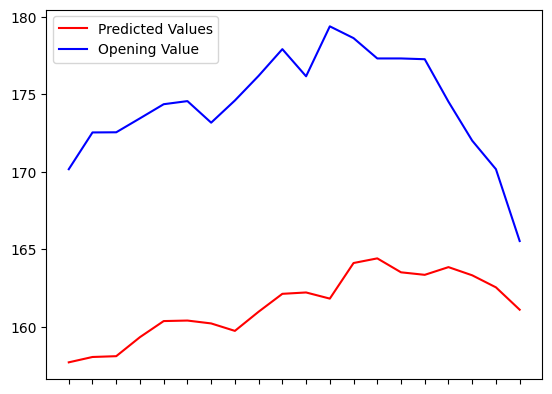

In [40]:
#now, let's visualize our predicted values
plt.plot(df_preds['Date'], df_preds['Open_Pred'], color = 'red', label = 'Predicted Values')
plt.plot(df_preds['Date'], df_preds['Open'], color = 'blue', label = 'Opening Value')
plt.legend()
plt.xticks(visible = False)
plt.show()

It seems that the addition of the datetime features, in this case, worsened the model's performance. There is an obviously much larger gap in the model predictions and the true values for this desgin matrix, with no overlap between true and predicted values at all.